<img src = "../../Data/bgsedsc_0.jpg">

# Project: Decision trees

## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ DT method(s) have been used - 25%
+ Length of stay for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


In [1]:
# Starter code to load data
import pandas as pd
# Training dataset
data=pd.read_csv('Data/mimic_train.csv')
data.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [2]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('Data/mimic_test_los.csv')
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [6]:
#this is just for not loosing id column. It is necassary for Kaggle upload.
test_id=pd.DataFrame()
test_id["icustay_id"]=data_test["icustay_id"]

In [7]:
test_id

,icustay_id
0,208169
1,251754
2,242171
3,263035
4,279388
...,...
5216,278087
5217,266914
5218,213413
5219,286384


In [8]:
# Sample output prediction file
pred_sample=pd.read_csv('Data/mimic_kaggle_los_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,LOS
663,200011,3.701046
4608,200044,3.701046
1186,200049,3.701046
1245,200063,3.701046
606,200081,3.701046


In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures as plf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler

In [10]:
data["visits_ICU"] = data.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
data_test["visits_ICU"] = data_test.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1

In [11]:
data[["subject_id", "ADMITTIME", "visits_ICU"]].sort_values(["subject_id", "ADMITTIME"]).iloc[:13]

,subject_id,ADMITTIME,visits_ICU
18310,23,2157-10-18 19:34:00,1
17908,34,2191-02-23 05:23:00,1
9591,36,2134-05-10 11:30:00,1
727,85,2167-07-25 18:49:00,1
16007,109,2141-03-27 21:08:00,1
13738,109,2141-05-24 14:47:00,2
4002,109,2141-09-05 20:04:00,3
12883,109,2141-09-11 10:12:00,4
17983,109,2141-09-18 10:32:00,5
8222,109,2141-10-13 23:10:00,6


In [12]:
comorbidities = pd.read_csv("Data/extra_data/MIMIC_diagnoses.csv")
comorbidities.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [13]:
number_comorbidities_patient = comorbidities.groupby(["SUBJECT_ID", "HADM_ID"]).max()["SEQ_NUM"].reset_index()
number_comorbidities_patient = number_comorbidities_patient.rename({"SEQ_NUM": "number_comorbidities"}, axis=1)
number_comorbidities_patient

,SUBJECT_ID,HADM_ID,number_comorbidities
0,2,163353,3.0
1,3,145834,9.0
2,4,185777,9.0
3,5,178980,3.0
4,6,107064,8.0
...,...,...,...
58971,99985,176670,13.0
58972,99991,151118,17.0
58973,99992,197084,12.0
58974,99995,137810,17.0


In [14]:
# Join with training set
data = pd.merge(data, number_comorbidities_patient, left_on=["subject_id", "hadm_id"], right_on = ["SUBJECT_ID", "HADM_ID"], how = "left").drop(["SUBJECT_ID", "HADM_ID"], axis=1)

# Join with test set
data_test = pd.merge(data_test, number_comorbidities_patient, left_on=["subject_id", "hadm_id"], right_on = ["SUBJECT_ID", "HADM_ID"], how = "left").drop(["SUBJECT_ID", "HADM_ID"], axis=1)

In [15]:
data['MARITAL_STATUS'] = data['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
data_test['MARITAL_STATUS'] = data_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [16]:
#filing missing data with subject_id
data = data.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())
data_test = data_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())

In [17]:
data.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           1937
HeartRate_Max           1937
HeartRate_Mean          1937
SysBP_Min               1957
SysBP_Max               1957
SysBP_Mean              1957
DiasBP_Min              1958
DiasBP_Max              1958
DiasBP_Mean             1958
MeanBP_Min              1937
MeanBP_Max              1937
MeanBP_Mean             1937
RespRate_Min            1938
RespRate_Max            1938
RespRate_Mean           1938
TempC_Min               2207
TempC_Max               2207
TempC_Mean              2207
SpO2_Min                1952
SpO2_Max                1952
SpO2_Mean               1952
Glucose_Min              214
Glucose_Max              214
Glucose_Mean             214
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION      

In [18]:
data = data.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
data_test = data_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())

In [19]:
#we still have missing data but its lower than before
data.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           1787
HeartRate_Max           1787
HeartRate_Mean          1787
SysBP_Min               1804
SysBP_Max               1804
SysBP_Mean              1804
DiasBP_Min              1805
DiasBP_Max              1805
DiasBP_Mean             1805
MeanBP_Min              1788
MeanBP_Max              1788
MeanBP_Mean             1788
RespRate_Min            1787
RespRate_Max            1787
RespRate_Mean           1787
TempC_Min               2028
TempC_Max               2028
TempC_Mean              2028
SpO2_Min                1800
SpO2_Max                1800
SpO2_Mean               1800
Glucose_Min              191
Glucose_Max              191
Glucose_Mean             191
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION      

In [20]:
#data has some unrealistic values in admit time and dob.
#I calculate age when the patient admit 

#spliting date values into day, month and year
data['real_admittime'] = np.nan
data['real_dob'] = np.nan
for i in range(len(data)):
    admit_datetime = datetime.strptime(data['ADMITTIME'].iloc[i], '%Y-%m-%d %H:%M:%S')
    eps = timedelta(days = data['Diff'].iloc[i])
    real_admit = admit_datetime + eps
    data['real_admittime'].iloc[i] = real_admit

for i in range(len(data)):
    dob_datetime = datetime.strptime(data['DOB'].iloc[i], '%Y-%m-%d %H:%M:%S')
    eps = timedelta(days = data['Diff'].iloc[i])
    real_dob = dob_datetime + eps
    data['real_dob'].iloc[i] = real_dob
    
data = data.drop(['ADMITTIME', 'DOB'], axis = 1)
data['age_at_admin'] = np.nan

for i in range(len(data)):
    data['age_at_admin'].iloc[i] = data['real_admittime'].iloc[i] - data['real_dob'].iloc[i]
    data['age_at_admin'].iloc[i] = data['age_at_admin'].iloc[i].days / 365

data = data.drop(['real_admittime', 'real_dob', 'Diff'], axis = 1)
print(data['age_at_admin'].isnull().any() )

C:\Users\FDN-Aysu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


False


In [21]:
#same process for test set 
data_test['real_admittime'] = np.nan
data_test['real_dob'] = np.nan
for i in range(len(data_test)):
    admit_datetime = datetime.strptime(data_test['ADMITTIME'].iloc[i], '%Y-%m-%d %H:%M:%S')
    eps = timedelta(days = data_test['Diff'].iloc[i])
    real_admit = admit_datetime + eps
    data_test['real_admittime'].iloc[i] = real_admit

for i in range(len(data_test)):
    dob_datetime = datetime.strptime(data_test['DOB'].iloc[i], '%Y-%m-%d %H:%M:%S')
    eps = timedelta(days = data_test['Diff'].iloc[i])
    real_dob = dob_datetime + eps
    data_test['real_dob'].iloc[i] = real_dob
    
data_test = data_test.drop(['ADMITTIME', 'DOB'], axis = 1)
data_test['age_at_admin'] = np.nan

for i in range(len(data_test)):
    data_test['age_at_admin'].iloc[i] = data_test['real_admittime'].iloc[i] - data_test['real_dob'].iloc[i]
    data_test['age_at_admin'].iloc[i] = data_test['age_at_admin'].iloc[i].days / 365

data_test = data_test.drop(['real_admittime', 'real_dob', 'Diff'], axis = 1)
print(data_test['age_at_admin'].isnull().any() )

False


C:\Users\FDN-Aysu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\FDN-Aysu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


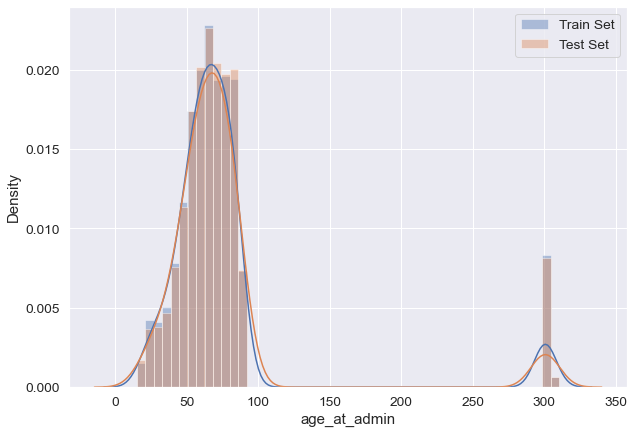

In [22]:
#showing the age at admit date
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("darkgrid")
sns.distplot(data['age_at_admin'], label='Train Set')
sns.distplot(data_test['age_at_admin'], label='Test Set')
plt.legend()

#as we can see some patients are 300 years old

C:\Users\FDN-Aysu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\FDN-Aysu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


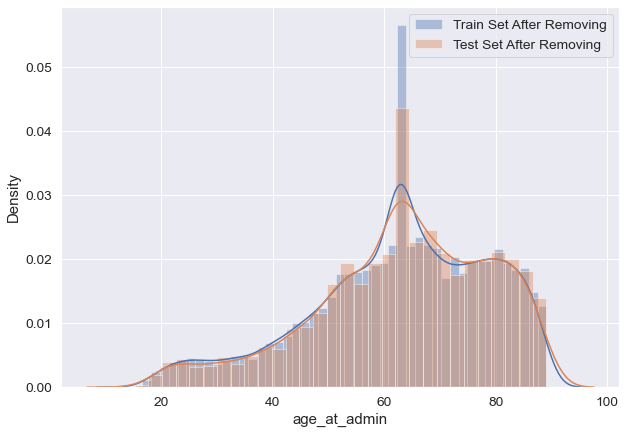

In [23]:
#for better train and test data I changed ages more than 100 with mean age
mean_age_train = data.loc[data['age_at_admin']<100, 'age_at_admin'].mean()

data.loc[data.age_at_admin >= 100, 'age_at_admin'] = np.nan
data['age_at_admin'].fillna(mean_age_train, inplace=True)

data_test.loc[data_test.age_at_admin >= 100, 'age_at_admin'] = np.nan
data_test['age_at_admin'].fillna(mean_age_train, inplace=True)

#data.drop(data[data['age_at_admin']>= 100].index ,inplace = True)
#data_test.drop(data_test[data_test['age_at_admin']>= 100].index ,inplace = True)
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("darkgrid")
sns.distplot(data['age_at_admin'], label='Train Set After Removing')
sns.distplot(data_test['age_at_admin'], label='Test Set After Removing')
plt.legend()

In [24]:
data['ETHNICITY'] = data['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

data['ETHNICITY'] = data['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

data['ETHNICITY'] = data['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

data['ETHNICITY'] = data['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

data['ETHNICITY'] = data['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

data['ETHNICITY'] = data['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')

In [25]:
data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')

In [26]:
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
data['RELIGION'] = data['RELIGION'].replace(religion_other, 'OTHER')
data_test['RELIGION'] = data_test['RELIGION'].replace(religion_other, 'OTHER')

In [27]:
y_train = data["LOS"]
data = data.drop(["HOSPITAL_EXPIRE_FLAG","subject_id","hadm_id","icustay_id","LOS","DIAGNOSIS"], axis = 1)

In [28]:
X_train=data

In [29]:
num_feat_df = X_train.select_dtypes(exclude=['object', 'category'])
cat_feat_df = X_train.select_dtypes(include=['object', 'category'])
icd9_feat_df = cat_feat_df['ICD9_diagnosis']
cat_feat_df = cat_feat_df.drop('ICD9_diagnosis',axis=1) 

In [30]:
# Update list of numerical and categorical features
num_feat = X_train.select_dtypes(exclude=['object', 'category']).columns
print(num_feat)

cat_feat = X_train.select_dtypes(include=['object', 'category']).columns

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat = ['ICD9_diagnosis']
cat_feat = cat_feat.drop(['ICD9_diagnosis']) 
print(icd9_feat)
print(cat_feat)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'visits_ICU', 'number_comorbidities', 'age_at_admin'],
      dtype='object')
['ICD9_diagnosis']
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')


In [31]:
print("Features in train data but not in test:")
print(data.columns.difference(data_test.columns) )

print("\nFeatures in test data but not in train:")
print(data_test.columns.difference(data.columns) )

Features in train data but not in test:
Index([], dtype='object')

Features in test data but not in train:
Index(['DIAGNOSIS', 'hadm_id', 'icustay_id', 'subject_id'], dtype='object')


In [32]:
data_test = data_test.drop(["subject_id","hadm_id","icustay_id","DIAGNOSIS"], axis = 1)

In [33]:
X_test=data_test

In [34]:
num_feat_test_df = X_test.select_dtypes(exclude=['object', 'category'])
cat_feat_test_df = X_test.select_dtypes(include=['object', 'category'])
icd9_feat_test_df = cat_feat_test_df['ICD9_diagnosis']
cat_feat_test_df = cat_feat_test_df.drop('ICD9_diagnosis',axis=1) 

In [35]:
# Update list of numerical and categorical features
num_feat_test = X_test.select_dtypes(exclude=['object', 'category']).columns
print(num_feat_test)

cat_feat_test = X_test.select_dtypes(include=['object', 'category']).columns

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat_test = ['ICD9_diagnosis']
cat_feat_test = cat_feat_test.drop(['ICD9_diagnosis']) 
print(icd9_feat_test)
print(cat_feat_test)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'visits_ICU', 'number_comorbidities', 'age_at_admin'],
      dtype='object')
['ICD9_diagnosis']
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')


I didn't use pipeline. I go with the option step by step.
First, dividing data into 3 parts:

1. Numerical data

2. Categorical data

3. ICD9 Diagnosis data


For categorical, I used OneHotEncoder and StandartScaler. For diagnosis, TargetEncoder and StandartScaler. Lastly, I used SimpleImputer for numerical data

In [36]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(num_feat_df)
num_feat_df = imputer.transform(num_feat_df)
num_feat_test_df = imputer.transform(num_feat_test_df)


In [37]:
num_feat_df=pd.DataFrame(num_feat_df)

In [38]:
num_feat_test_df=pd.DataFrame(num_feat_test_df)

I renamed column names of numerical data manually. Because transform function turns data into numpy array. However, we need a dataframe for working with machine learning algorithms. 

In [39]:
num_feat_df.rename(columns={0: 'HeartRate_Min', 1: 'HeartRate_Max',
                           2:'HeartRate_Mean', 3:'SysBP_Min',
                           4:'SysBP_Max', 5:'SysBP_Mean',
                           6:'DiasBP_Min', 7:'DiasBP_Max',
                           8:'DiasBP_Mean', 9:'MeanBP_Min',
                           10:'MeanBP_Max', 11:'MeanBP_Mean',
                           12:'RespRate_Min', 13:'RespRate_Max',
                           14:'RespRate_Mean', 15:'TempC_Min',
                            16:'TempC_Max', 17:'TempC_Mean',
                            18:'SpO2_Min', 19:'SpO2_Max',
                            20:'SpO2_Mean', 21:'Glucose_Min',
                            22:'Glucose_Max', 23:'Glucose_Mean',
                            24:'visits_ICU', 25:'number_comorbidities',
                            26:'age_at_admin'},inplace=True)


In [40]:
num_feat_test_df.rename(columns={0: 'HeartRate_Min', 1: 'HeartRate_Max',
                           2:'HeartRate_Mean', 3:'SysBP_Min',
                           4:'SysBP_Max', 5:'SysBP_Mean',
                           6:'DiasBP_Min', 7:'DiasBP_Max',
                           8:'DiasBP_Mean', 9:'MeanBP_Min',
                           10:'MeanBP_Max', 11:'MeanBP_Mean',
                           12:'RespRate_Min', 13:'RespRate_Max',
                           14:'RespRate_Mean', 15:'TempC_Min',
                            16:'TempC_Max', 17:'TempC_Mean',
                            18:'SpO2_Min', 19:'SpO2_Max',
                            20:'SpO2_Mean', 21:'Glucose_Min',
                            22:'Glucose_Max', 23:'Glucose_Mean',
                            24:'visits_ICU', 25:'number_comorbidities',
                            26:'age_at_admin'},inplace=True)

In [41]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [42]:
cat_encoder.fit(cat_feat_df)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [43]:
cat_feat_df=cat_encoder.transform(cat_feat_df)
cat_feat_test_df=cat_encoder.transform(cat_feat_test_df)

In [44]:
cat_feat_df=pd.DataFrame(cat_feat_df)

In [45]:
cat_feat_test_df=pd.DataFrame(cat_feat_test_df)

In [46]:
import category_encoders as ce

icd9_encoder = ce.TargetEncoder(smoothing = 1.0)

In [47]:
icd9_encoder.fit(icd9_feat_df,y_train)

TargetEncoder(cols=['ICD9_diagnosis'])

In [48]:
icd9_feat_df=icd9_encoder.transform(icd9_feat_df)
icd9_feat_test_df=icd9_encoder.transform(icd9_feat_test_df)

In [49]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(num_feat_df)

In [50]:
num_feat_df=transformer.transform(num_feat_df)
num_feat_test_df=transformer.transform(num_feat_test_df)

In [51]:
num_feat_df=pd.DataFrame(num_feat_df)

In [52]:
num_feat_test_df=pd.DataFrame(num_feat_test_df)

In [53]:
num_feat_df.rename(columns={0: 'HeartRate_Min', 1: 'HeartRate_Max',
                           2:'HeartRate_Mean', 3:'SysBP_Min',
                           4:'SysBP_Max', 5:'SysBP_Mean',
                           6:'DiasBP_Min', 7:'DiasBP_Max',
                           8:'DiasBP_Mean', 9:'MeanBP_Min',
                           10:'MeanBP_Max', 11:'MeanBP_Mean',
                           12:'RespRate_Min', 13:'RespRate_Max',
                           14:'RespRate_Mean', 15:'TempC_Min',
                            16:'TempC_Max', 17:'TempC_Mean',
                            18:'SpO2_Min', 19:'SpO2_Max',
                            20:'SpO2_Mean', 21:'Glucose_Min',
                            22:'Glucose_Max', 23:'Glucose_Mean',
                            24:'visits_ICU', 25:'number_comorbidities',
                            26:'age_at_admin'},inplace=True)


In [54]:
num_feat_test_df.rename(columns={0: 'HeartRate_Min', 1: 'HeartRate_Max',
                           2:'HeartRate_Mean', 3:'SysBP_Min',
                           4:'SysBP_Max', 5:'SysBP_Mean',
                           6:'DiasBP_Min', 7:'DiasBP_Max',
                           8:'DiasBP_Mean', 9:'MeanBP_Min',
                           10:'MeanBP_Max', 11:'MeanBP_Mean',
                           12:'RespRate_Min', 13:'RespRate_Max',
                           14:'RespRate_Mean', 15:'TempC_Min',
                            16:'TempC_Max', 17:'TempC_Mean',
                            18:'SpO2_Min', 19:'SpO2_Max',
                            20:'SpO2_Mean', 21:'Glucose_Min',
                            22:'Glucose_Max', 23:'Glucose_Mean',
                            24:'visits_ICU', 25:'number_comorbidities',
                            26:'age_at_admin'},inplace=True)


In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [56]:
scaler.fit(cat_feat_df)

StandardScaler()

In [57]:
cat_feat_df=scaler.transform(cat_feat_df)
cat_feat_test_df=scaler.transform(cat_feat_test_df)

In [58]:
cat_feat_df=pd.DataFrame(cat_feat_df)

In [59]:
cat_feat_test_df=pd.DataFrame(cat_feat_test_df)

In [60]:
scaler_icd = StandardScaler()

In [61]:
scaler_icd.fit(icd9_feat_df)

StandardScaler()

In [62]:
icd9_feat_df=scaler_icd.transform(icd9_feat_df)
icd9_feat_test_df=scaler_icd.transform(icd9_feat_test_df)

In [63]:
icd9_feat_df=pd.DataFrame(icd9_feat_df)
icd9_feat_test_df=pd.DataFrame(icd9_feat_test_df)

In [64]:
icd9_feat_df=icd9_feat_df.rename(columns={0:"icd9"})

In [65]:
icd9_feat_test_df=icd9_feat_test_df.rename(columns={0:"icd9"})

In [66]:
X_train = pd.concat([num_feat_df, icd9_feat_df, cat_feat_df], axis = 1)
X_test = pd.concat([num_feat_test_df, icd9_feat_test_df, cat_feat_test_df], axis = 1)

In [67]:
X_train.columns

Index([       'HeartRate_Min',        'HeartRate_Max',       'HeartRate_Mean',
                  'SysBP_Min',            'SysBP_Max',           'SysBP_Mean',
                 'DiasBP_Min',           'DiasBP_Max',          'DiasBP_Mean',
                 'MeanBP_Min',           'MeanBP_Max',          'MeanBP_Mean',
               'RespRate_Min',         'RespRate_Max',        'RespRate_Mean',
                  'TempC_Min',            'TempC_Max',           'TempC_Mean',
                   'SpO2_Min',             'SpO2_Max',            'SpO2_Mean',
                'Glucose_Min',          'Glucose_Max',         'Glucose_Mean',
                 'visits_ICU', 'number_comorbidities',         'age_at_admin',
                       'icd9',                      0,                      1,
                            2,                      3,                      4,
                            5,                      6,                      7,
                            8,                      

In [77]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

I used GridSearchCV for hyper parameter optimization. Results are saved in models variable.

In [78]:
SEED = 4
# models
models = [XGBRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [xgb_params, dectree_params, randomforest_params, adab_params, gb_params]
names = ['XGB_Regressor', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = GridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
   

    models[i].set_params(**best_model.best_params_)
    


Grid-Searching for model XGB_Regressor...
Best model fitted
Grid-Searching for model DecisionTree_Regressor...


C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best model fitted
Grid-Searching for model RandomForest_Regressor...


C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best model fitted
Grid-Searching for model AdaBoost_Regressor...


C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best model fitted
Grid-Searching for model GradientBoosting_Regressor...


C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best model fitted


C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [79]:
models

[XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=1.5,
              scale_pos_weight=None, seed=4, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 DecisionTreeRegressor(max_depth=5, max_features=8, min_samples_leaf=9,
                       random_state=4),
 RandomForestRegressor(max_depth=5, max_features=9, min_samples_leaf=6,
                       random_state=4),
 AdaBoostRegressor(learning_rate=0.05, random_state=4),
 GradientBoostingRegressor(learn

I tried each models with their best parameter using .predict function.Because of time constrain, I uploaded predictions to the kaggle. Kaggle gave best solution with XGBRegressor. So, I continued with that algorithm. 


Otherwise It can be decided with train test split. We can measure how good is with MSE.

In [81]:
final_model=XGBRegressor(learning_rate=0.05, max_delta_step=None, max_depth=6,
              min_child_weight=5,n_estimators=100, reg_lambda=1.5, seed=4)

In [82]:
final_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=4, reg_alpha=0,
             reg_lambda=1.5, scale_pos_weight=1, seed=4, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
y_hat2 = final_model.predict(X_test)

In [87]:
#submitting for Kaggle
test_predictions_submit = pd.DataFrame({"icustay_id": test_id["icustay_id"], "LOS": y_hat2})
test_predictions_submit.to_csv("test_predictions_submit_dt.csv", index = False)

Feature Importance

In [88]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [89]:
feature_names = X_train.columns

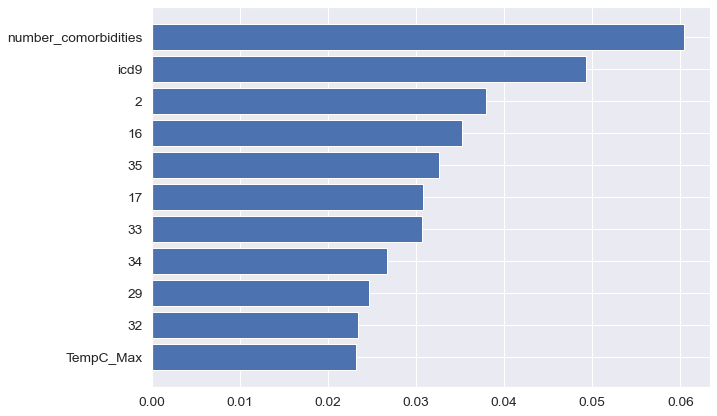

In [91]:
import matplotlib.pylab as plt
xgb_opt = models[0].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), feature_names)

The features which are shown as numerical values are our categorical values. (Transform method changed names of columns as numerical order). In here 2 is ADMISSION_TYPE

C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


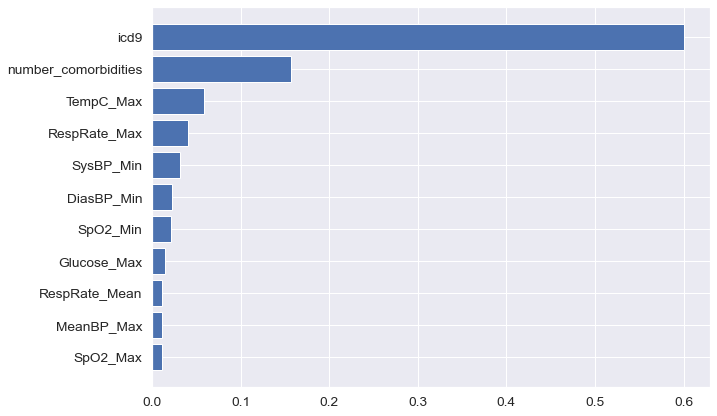

In [94]:
dectree_opt = models[1].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(dectree_opt.feature_importances_), feature_names)

C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


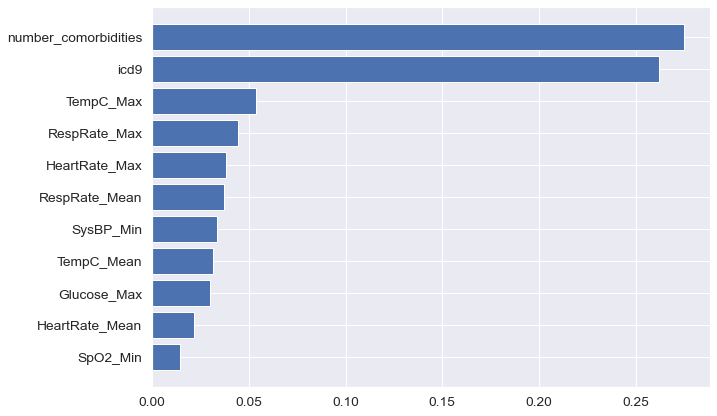

In [95]:
randomforest_opt = models[2].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(randomforest_opt.feature_importances_), feature_names)

C:\Users\FDN-Aysu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


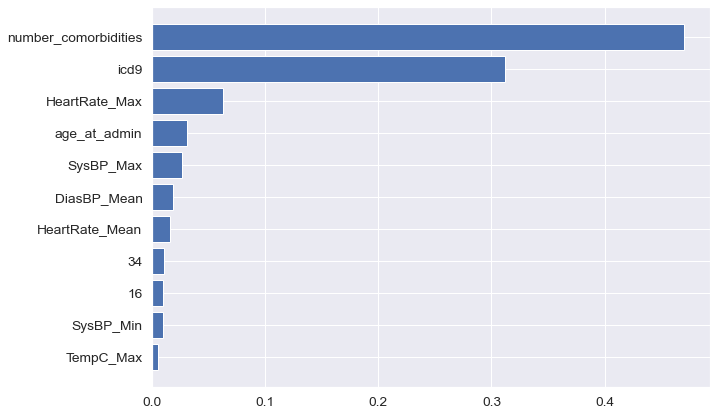

In [96]:
adab_opt = models[3].fit(X_train, y_train)
feat_indexes_adab = feature_imp(abs(adab_opt.feature_importances_), feature_names)